In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from data_collector import AmtrackDataCollector

collector = AmtrackDataCollector("data/raw/raw.json")

raw_data = collector.get_train_data()

print(f"Number of train groups: {len(raw_data)}")

first_train_key = list(raw_data.keys())[0]
first_train = raw_data[first_train_key][0]

print(f"Keys in first train: {list(first_train.keys())}")
print(f"Station values in first train: {(first_train['stations'][0].keys())}")

No data file found, fetching from API
Success!
Number of train groups: 173
Keys in first train: ['routeName', 'trainNum', 'trainNumRaw', 'trainID', 'lat', 'lon', 'trainTimely', 'iconColor', 'textColor', 'stations', 'heading', 'eventCode', 'eventTZ', 'eventName', 'origCode', 'originTZ', 'origName', 'destCode', 'destTZ', 'destName', 'trainState', 'velocity', 'statusMsg', 'createdAt', 'updatedAt', 'lastValTS', 'objectID', 'provider', 'providerShort', 'onlyOfTrainNum', 'alerts']
Station values in first train: dict_keys(['name', 'code', 'tz', 'bus', 'schArr', 'schDep', 'arr', 'dep', 'arrCmnt', 'depCmnt', 'status', 'stopIconColor', 'platform'])


In [2]:
train_records = []
for train_number, train_list in raw_data.items():
  for train in train_list:
    train_record = {
      'train_number': train_number,
      'route_name': train.get('routeName', ''),
      'train_id': train.get('trainID', ''),
      'lat': train.get('lat'),
      'lon': train.get('lon'),
      'heading': train.get('heading', ''),
      'velocity': train.get('velocity'),
      'train_state': train.get('trainState', ''),
      'status_msg': train.get('statusMsg', ''),
      'origin_code': train.get('origCode', ''),
      'dest_code': train.get('destCode', ''),
      'num_stations': len(train.get('stations', []))
    }
    train_records.append(train_record)

trains_df = pd.DataFrame(train_records)
print("TRAINS DataFrame:")
print(trains_df.head())
print(f"Shape: {trains_df.shape}")

TRAINS DataFrame:
  train_number       route_name train_id        lat         lon heading  \
0            1   Sunset Limited      1-6  31.861696 -106.697413      NW   
1            2   Sunset Limited      2-6  31.845735 -106.672610       S   
2            3  Southwest Chief      3-6  35.509256 -105.858309      SW   
3            3  Southwest Chief      3-7  41.547459  -89.117949       S   
4            4  Southwest Chief      4-5  41.432148  -89.346884      NE   

    velocity train_state status_msg origin_code dest_code  num_stations  
0  37.599159      Active                    NOL       LAX            22  
1  38.189461      Active                    LAX       NOL            22  
2  21.281960      Active                    CHI       LAX            32  
3   0.000000      Active                    CHI       LAX            32  
4  77.708656      Active                    LAX       CHI            32  
Shape: (189, 12)


In [3]:
station_records = []
for train_number, train_list in raw_data.items():
  for train in train_list:
    route_name = train.get('routeName', '')
    train_id = train.get('trainID', '')
    
    for station in train.get('stations', []):
      station_record = {
        'train_number': train_number,
        'train_id': train_id,
        'route_name': route_name,
        'station_name': station.get('name', ''),
        'station_code': station.get('code', ''),
        'scheduled_arrival': station.get('schArr'),
        'actual_arrival': station.get('arr'),
        'scheduled_departure': station.get('schDep'),
        'actual_departure': station.get('dep'),
        'status': station.get('status', ''),
        'timezone': station.get('tz', ''),
      }
      station_records.append(station_record)

stations_df = pd.DataFrame(station_records)

time_columns = ['scheduled_arrival', 'actual_arrival', 'scheduled_departure', 'actual_departure']
for col in time_columns:
  stations_df[col] = pd.to_datetime(stations_df[col], errors='coerce', utc=True)

print("\nSTATIONS DataFrame:")
print(stations_df.head())
print(f"Shape: {stations_df.shape}")



STATIONS DataFrame:
  train_number train_id      route_name  station_name station_code  \
0            1      1-6  Sunset Limited   New Orleans          NOL   
1            1      1-6  Sunset Limited     Schriever          SCH   
2            1      1-6  Sunset Limited    New Iberia          NIB   
3            1      1-6  Sunset Limited     Lafayette          LFT   
4            1      1-6  Sunset Limited  Lake Charles          LCH   

          scheduled_arrival            actual_arrival  \
0 2025-08-06 14:00:00+00:00 2025-08-06 14:00:00+00:00   
1 2025-08-06 15:30:00+00:00 2025-08-06 15:39:00+00:00   
2 2025-08-06 16:56:00+00:00 2025-08-06 17:06:00+00:00   
3 2025-08-06 17:24:00+00:00 2025-08-06 17:32:00+00:00   
4 2025-08-06 18:55:00+00:00 2025-08-06 19:03:00+00:00   

        scheduled_departure          actual_departure    status  \
0 2025-08-06 14:00:00+00:00 2025-08-06 14:00:00+00:00  Departed   
1 2025-08-06 15:30:00+00:00 2025-08-06 15:40:00+00:00  Departed   
2 2025-08-06 1

['Very Early', 'Slightly Early', 'On Time', 'Slightly Late', 'Late', 'Very Late']
[np.int64(376), np.int64(1639), np.int64(435), np.int64(393), np.int64(326), np.int64(337)]


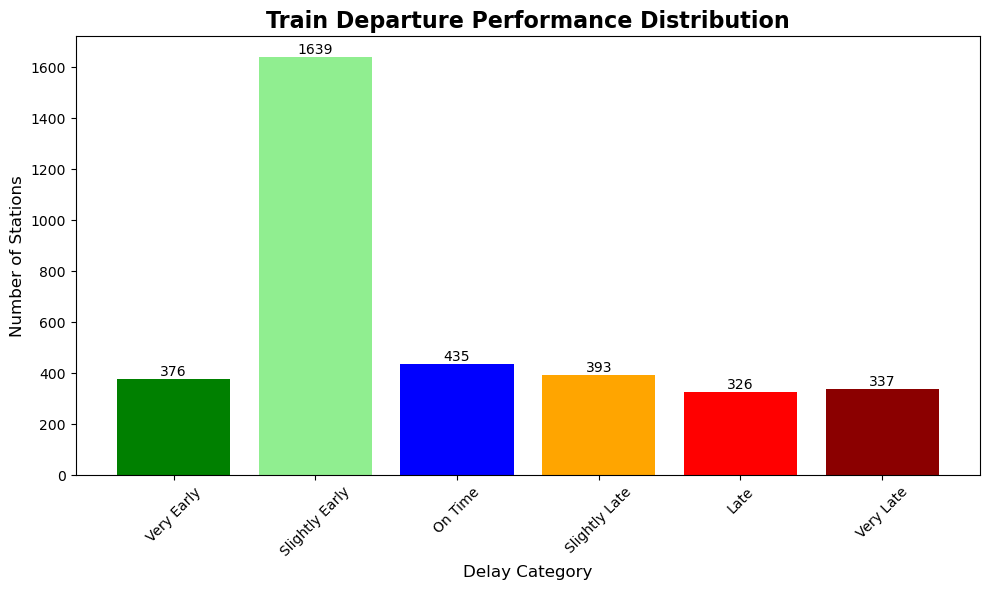

Very Early percentage: 10.7%
Slightly Early percentage: 46.7%
On Time percentage: 12.4%
Slightly Late percentage: 11.2%
Late percentage: 9.3%
Very Late percentage: 9.6%


In [4]:
stations_df['scheduled_departure_utc'] = pd.to_datetime(stations_df['scheduled_departure']).dt.tz_convert('UTC')
stations_df['actual_departure_utc'] = pd.to_datetime(stations_df['actual_departure']).dt.tz_convert('UTC')

stations_df["departure_delay_minutes"] = (stations_df['actual_departure'] - stations_df['scheduled_departure']).dt.total_seconds() / 60
stations_df["arrival_delay_minutes"] = (stations_df['actual_arrival'] - stations_df['scheduled_arrival']).dt.total_seconds() / 60

# print(f"Departure delays: {stations_df.departure_delay_minutes.head()}")
# print(f"Arrival delays: {stations_df.arrival_delay_minutes.head()}")

# print(f"Total departure delays: {stations_df.departure_delay_minutes.gt(0).sum()}")
# print(f"Total arrival delays: {stations_df.arrival_delay_minutes.gt(0).sum()}")

# Data visualization for delays.
plt.figure(figsize=(10, 6))
delay_bins = [-60, -5, 5, 15, 30, 60, 999]
delay_labels = ['Very Early', 'Slightly Early', 'On Time', 'Slightly Late', 'Late', 'Very Late']
delay_colors = ['green', 'lightgreen', 'blue', 'orange', 'red', 'darkred']
stations_df['delay_category'] = pd.cut(
    stations_df['departure_delay_minutes'], 
    bins=delay_bins, 
    labels=delay_labels
)
delay_counts = stations_df['delay_category'].value_counts()
ordered_categories = delay_labels
ordered_counts = [delay_counts.get(category, 0) for category in ordered_categories]

print(ordered_categories)
print(ordered_counts)
bars = plt.bar(ordered_categories, ordered_counts, color=delay_colors)
plt.title('Train Departure Performance Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Delay Category', fontsize=12)
plt.ylabel('Number of Stations', fontsize=12)
plt.xticks(rotation=45)
for bar, count in zip(bars, ordered_counts):
  x_position = bar.get_x() + bar.get_width()/2.
  y_position = count + 0.5
  plt.text(x_position, y_position, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

delay_counts_sum = delay_counts.sum()
for category, count in zip(ordered_categories, ordered_counts):
  print(f"{category} percentage: {round(count/delay_counts_sum*100,1)}%")



'\ncalifornia_zephr = stations_df.loc[\n  (stations_df.route_name == "California Zephyr") & \n  (stations_df.departure_delay_minutes > 300)]\n'

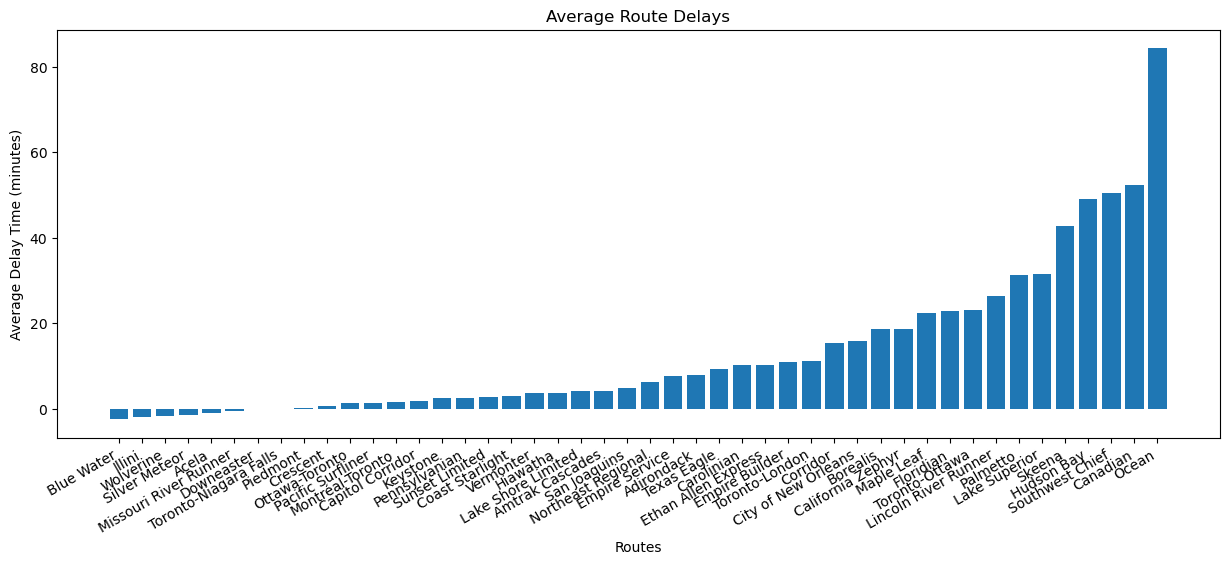

In [5]:
route_delays = stations_df.groupby('route_name')['departure_delay_minutes'].agg(['mean', 'count'])
route_delays = route_delays[route_delays['count'] >= 5]
route_delays = route_delays.sort_values(by='mean')
# print(route_delays)


plt.figure(figsize=(15, 6))
plt.bar(route_delays.index, route_delays['mean'])
plt.title('Average Route Delays')
plt.xlabel('Routes')
plt.ylabel('Average Delay Time (minutes)')
plt.gcf().autofmt_xdate()

plt.plot

'''
california_zephr = stations_df.loc[
  (stations_df.route_name == "California Zephyr") & 
  (stations_df.departure_delay_minutes > 300)]
'''